In [1]:
# import libraries
import sys
import os
from functools import partial
import geopandas
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, Counter, deque
from itertools import chain

# turn off warnings
warnings.simplefilter("ignore")

# append the system path with `/python_framework` directory
# this is where some useful network analysis functions are stored
sys.path.append(r"../src/python_framework_v02")

# import t-route functions for network analysis
import nhd_io
import nhd_network
import nhd_network_utilities_v02 as nnu

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True
    root = r"/content/t-route"
    subprocess.run(["git", "clone", "https://github.com/NOAA-OWP/t-route.git"])
except:
    root = os.path.dirname(os.path.abspath(""))

# Decomposing supernetworks into networks and reaches
- A key contribution of the t-route repository is the efficient decomposition of the national river network into subnetworks and interconnected reaches. This is important because:

    1. Routing models are applied at the reach-scale
    
    2. Connections between reaches must be specified in order to maintain mass and momentum balance at the network scale (i.e the water from upstream reaches flows into downstream reaches)
    
    3. Independent subnetworks can be evaluated in parallel, which greatly reduces computational time  

- A few definitions are necessary here:
    - **Segment** - the elementary building blocks of a stream network defined as a linear strech of river with a certain length and uniform geomorphic parameters (e.g. width, slope, roughness, etc). Segments are the nodes in generic network lingo. 
    
    - **Reach** - A linear combination of segments between two junction points, between a headwater and a junction, or between a junction and a tailwater. 
    
    - **Subnetwork** - A series of connected segments (and reaches) that drain to the same tailwater.
    
    - **Supernetwork** - A large assembly of stream segments, often composing many different subnetworks.
    
- In practice we start with a *supernetwork* of connected and disconnected stream segments. For example, the NHDPlus dataset is a *supernetwork* that represents all of the mapped streams and rivers in the United States. 

- How then do we go about subdividing the *supernetwork* into constituent *subnetworks* and *reaches*?

- The t-route repository contains a library of network analysis functions that solve this problem.

- This notebook illustrates how network analysis functions are used to decompose the main stem CONUS stream network into constituent subnetworks and reaches. 


## Identify the supernetwork data
- First, we need to identify the supernetwork data
- A function called `set_supernetwork_data` returns key metadata for the supernetwork. 
- In the cell below, you can experiment with different supernetwork options by commenting/uncommenting definitions for the variable, `supernetwork`.

In [2]:
# join /test/input/geo directory to the path - this is where geospatial test data are stored
geo_input_folder = os.path.join(r"../test/input/geo")

# Specify the supernetwork, for this example we will work with Mainstem_CONUS
supernetwork = "Mainstems_CONUS"

# get supernetwork information
network_data = nnu.set_supernetwork_data(
    supernetwork=supernetwork, geo_input_folder=geo_input_folder
)

# network data is a dictionary containing many useful metadata attributes for the supernetwork
print(network_data)


{'geo_file_path': '../test/input/geo/Channels/RouteLink_NHDPLUS.nwm.v2.0.2.nc', 'data_link': 'https://www.nco.ncep.noaa.gov/pmb/codes/nwprod/nwm.v2.0.2/parm/domain/RouteLink_NHDPLUS.nc', 'key_col': 'link', 'downstream_col': 'to', 'length_col': 'Length', 'manningn_col': 'n', 'manningncc_col': 'nCC', 'slope_col': 'So', 'bottomwidth_col': 'BtmWdth', 'topwidth_col': 'TopWdth', 'topwidthcc_col': 'TopWdthCC', 'waterbody_col': 'NHDWaterbodyComID', 'waterbody_null_code': -9999, 'MusK_col': 'MusK', 'MusX_col': 'MusX', 'ChSlp_col': 'ChSlp', 'title_string': "CONUS 'Mainstems' (Channels below gages and AHPS prediction points)", 'driver_string': 'NetCDF', 'terminal_code': 0, 'layer_string': 0, 'mask_file_path': '../test/input/geo/Channels/masks/conus_Mainstem_links.txt', 'mask_driver_string': 'csv', 'mask_layer_string': '', 'mask_key': 0, 'mask_name': 1}


## Load and mask supernetwork data
- Now that we have identified the supernetwork ,we can load it and apply the appropriate mask. 
- Masks are used here for development purposes. It is helpful to reduce the size of supernetwork dataset before we go about analyzing it. 
- `data` is a DataFrame with as many rows as there are segments in the supernetwork. Columns in the DataFrame contain segment-specific Muskingum-Cunge parameters. 
- `dat_geo` is also a DataFrame with as many rows as there are segments in the supernetwork, but all data columns are retained. We are going to convert this DataFrame to a GeoDataFrame for visualization purposes.  

In [3]:
# read-in the network data as a pandas.GeoDataFrame using functions in `nhd_io.py`
data = nhd_io.read(network_data["geo_file_path"])

# grab column names from the network_data dictionary, by selecting keys that end with "_col"
# These will be used to select specific data columns from the GeoDataFrame
cols = [v for c, v in network_data.items() if c.endswith("_col")]

# retain a copy of the data set to be translated into a GeoDataFrame
dat_geo = data.copy()

# select only the columns we need from the GeoDataFrame, creating a new and smaller DataFrame
data = data[cols]

# set the Data Frame index (row labels) to the key column - "featureID"
data = data.set_index(network_data["key_col"])
dat_geo = dat_geo.set_index(network_data["key_col"])

# sort the DataFrame by featureID, ascending order.
data = data.sort_index()

# apply a mask to extract only a subset of the greater CONUS stream network
if "mask_file_path" in network_data:
    data_mask = nhd_io.read_mask(
        network_data["mask_file_path"], layer_string=network_data["mask_layer_string"],
    )
    data = data.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)
    dat_geo = dat_geo.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)


## Visualize the supernetwork
- To visualize the supernetwork, we need to convert the `dat_geo` DataFrame to a GeoDataFrame, named `gdf`.
- The GeoDataFrame contains geometry information that can be easily plotted.
- We make a simple map that represents all segments in the supernetwork as small points on a CONUS basemap. 

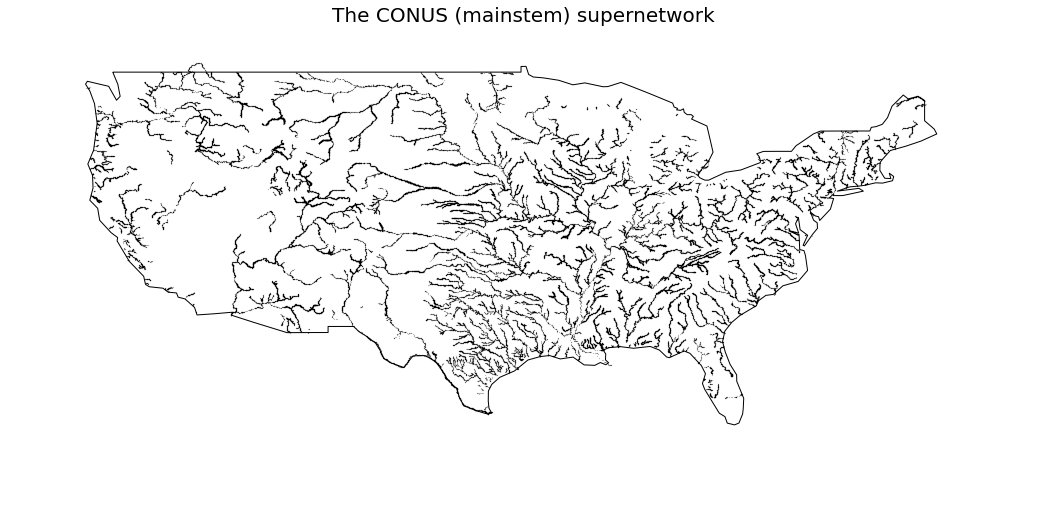

In [4]:
# create a GeoDataFrame for viz purposes
gdf = geopandas.GeoDataFrame(
    dat_geo, geometry=geopandas.points_from_xy(dat_geo.lon, dat_geo.lat)
)

# import world basemap
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# create a basemap showing the boundaries of the USA
base = world[world.name == "United States of America"].plot(
    color="white", edgecolor="black"
)

# add our stream network, segments are represented as small points (nodes in the network)
gdf.plot(ax=base, markersize=0.01, color="black")

# crop the map extent
base.set_xlim(-130, -60)
base.set_ylim(20, 52)

base.axis("off")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# add a title and display
plt.title("The CONUS (mainstem) supernetwork", fontsize=20)

plt.show()
fig.savefig("../doc/conus_supernetwork.png")


## Handle terminal segments
- In the native data, terminal segments (those that do not flow into another segment) have a downstream segment ID of zero in the downstream column of the DataFrame. This is problematic because all tailwaters point to a common drainage node, making it appear that all stream segments are part of the same network, which they are not. Therefore, it is necessary to create a new naming convention for the downstream connections of terminal segments. 
- The function `repace_downstreams` changes zeros to the negative of the terminal segment ID. For example, segment ID 12345 is a terminal segment, the downstream segment ID will be set to -12345. After applying this function, all tailwaters will now have a unique downstream connection. 

In [6]:
data = nhd_io.replace_downstreams(data, network_data["downstream_col"], 0)

## Extract network connections
- Downstream and upstream network connections are extracted with the `extract_network` and `reverse_network` functions, respectively.
- `extract_network` accepts the network DataFrame, `data`, and returns a dictionary of segments and their respective downstream connections. 
- `reverse_network` flips the edge orientation of the network such headwaters in the original become tailwaters in the reversed network. In doing so, each segment's upstream connections are identified. The function accepts the `connections` dictionary, and returns a dictionary of segments and their respective upstream connections. 

In [ ]:
# Given the network DataFrame, `extract_network` returns a dictionary segments and downstream connections.
# segment-id: [downstream-connected-segment-id]
connections = nhd_network.extract_connections(data, network_data["downstream_col"])

# flip the orientation of the network from headwaters -> tailwaters, to tailwaters -> headwaters
# this allows us to enumerate each segment's upstream neighbor
# segment-id: [upstream-connected-segment-id]
rconn = nhd_network.reverse_network(connections)


## Check that the supernetwork network is a Directed Acyclic Graph
- A [Directed Acyclic Graph (DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph) is a network consisting of many nodes and edges, each edge is *directed* from one node to another, and it is impossible to traverse the network in a way that the starting and ending nodes are the same (i.e. *acyclic*). 
- Because of gravity, river networks must be DAGs. Water must flow down energy gradients oriented in the direction of gravitational forces. As a result flows cannot "loop back" to an origination point. 
- To check that the supernetwork is a DAG, we use [Kahn's Algorithm](https://en.wikipedia.org/wiki/Topological_sorting#Kahn's_algorithm) for topological sorting.
- Subsequent network analyses assume *a priori* that the network is a DAG, so checking is critical. 

## Identify subnetworks
- The `reachable` function breaks the supernetwork into constituent subnetworks by extracting all segments connected to each tailwater segment. 
- The function accepts the reverse network dictionary, `rconn` (created in the cell above), and returns a dictionary, `subreachable`, containing a list of segments with connections to each tailwater segment in the supernetwork.
- Example output is shown for a single tailwater segment.

The function accepts a network (in this case the reversed network, rconn) and returns a dictionary where the keys are tailwater nodes and the values are the sets of nodes reachable from each tailwater node.

In [ ]:
# determine all of the stream segments with upstream connections to each tail water (terminal node) in the supernetwork
# note we hand the `reachable` function the reversed network dictionary `rconn`
# tailwater-segment-id: [list of ALL upstream connected segment ids]
subreachable = nhd_network.reachable(rconn)


## Visualize subnetworks
- Make a map showing each of the subnetworks in the supernetwork with different colors. 

In [ ]:
# Get the tailwater keys for each subnetwork
n_subnets = subreachable.keys()

# initialize a new column in the GeoDataFrame that will containa subnetwork code
gdf["subnetwork"] = 0

for i, reached in enumerate(subreachable.values(), 1):

    gdf.loc[gdf.index.isin(reached), "subnetwork"] = i

# CONUS basemap
base = world[world.name == "United States of America"].plot(
    color="white", edgecolor="black"
)

# add our stream network, using different marker colors for each subnetwork
gdf.plot(ax=base, markersize=0.01, column="subnetwork", cmap="prism")

# crop the map extent
base.set_xlim(-130, -60)
base.set_ylim(20, 52)

base.axis("off")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


plt.title("The supernetwork broken into subnetworks", fontsize=20)
plt.show()
fig.savefig("../doc/conus_networks.png")


## Identify reaches
- Identifying reaches in each subnetwork is a two step process
    1. Use the `reachable_network` function to identify the upstream connectivity structure of each subnetwork. The function accepts the reverse network dictionary, `rconn`, and returns a dictionary, `subnets_`, which lists upstream connections for each segment in each subnetwork. 
    2. Conduct a [depth-first-search](https://en.wikipedia.org/wiki/Depth-first_search) of each subnetwork. This is done with the `dfs_decomposition` function, which accepts the forward (downstream oriented) network dictionary, `nhd_network.reverse_network(net)`, and returns a dictionary of segment lists defining specific reaches in the subnetwork. Results from each subnetwork are concatenated into a larger dictionary, `subreaches`, which contains segment lists for all reaches in the supernetwork.    


In [ ]:
# create reverse connection dictionary for each subnetwork
# tailwater-segment-id: {segment-id: [upstream-connected-segment-id]}
subnets_ = nhd_network.reachable_network(rconn)

# create a dictionary, `subreaches` containing lists of all linear connected segments between junctions (reaches) in the supernetwork.
# Recall, a reach is composed of several interconnected segments between junctions.
# tailwater-segment-id: [[rch1-segment-id-1, rch1-segment-id-2, ..., rch1-segment-id-n],[rch2-segment-id1, rch2-segment-id2, ..., rch2-segment-id-n]]
subreaches = {}
for tw, net in subnets_.items():  # for the number of tailwaters in the supernetwork

    # I dont know what this does... something with identifying junctions
    path_func = partial(nhd_network.split_at_junction, net)

    # conduct a depth-first search to decompose the network into list of reaches
    reach = nhd_network.dfs_decomposition(nhd_network.reverse_network(net), path_func)

    # add reach list for subnetwork tw to the subreaches library
    subreaches[tw] = reach


## Visualize reaches in a single subnetwork
- Make a map showing each of the reaches in the Colorado River Basin subnetwork

In [ ]:
# extract a single large subnetwork from the supernetwork GeoDataFrame.
# Turns out that subnetwork code 4 is the Colorado River Basin
# !!! TODO: Create some sort of look up table to query river basins by name, rather than some arbitrary number
sub_gdf = gdf[gdf["subnetwork"] == 4]

# get reaches in the subnetwork
rchs = subreaches[list(sub_gdf[["to"]].idxmin())[0]]

# create a reach-code column in the GeoDataFrame
sub_gdf["reach"] = 0

# loop through all reaches in the subnetwork, populate the newly created "reach" column with an integer reach identification code
i = 1
for r in rchs:

    # get the stream segments in subnetwork `sub`
    A = [abs(ele) for ele in list(r)]

    # find the subnetwork rows in GeoDataFrame
    C = sub_gdf.index.isin(A)

    # Insert a subnetwork code in the `subnetwork` column of the GeoDataFrame
    sub_gdf.at[C, "reach"] = i

    # advance itteration index
    i = i + 1


# CONUS basemap
base = world[world.name == "United States of America"].plot(
    color="white", edgecolor="black"
)

sub_gdf.plot(ax=base, markersize=0.1, column="reach", cmap="prism")

# crop map extent
base.set_xlim(-130, -100)
base.set_ylim(20, 45)

base.axis("off")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.title("The Colorado River Basin subnetwork broken into reaches", fontsize=20)
plt.show()
fig.savefig("../doc/colorado_reaches.png")


## Recap
- This notebook illustrates how the t-route library analyzes network information to decompose supernetworks into constituent subnetworks and reaches. This is a critical component of the flood routing process that quantifies the complex connectivity of continental-scale river networks. 
- Key functions used in the t-route library include
    - `nhd_network_utilities_v02.set_supernetwork_data`
    - `nhd_io.read`
    - `nhd_network.extract_network`
    - `nhd_network.reverse_network`
    - `nhd_network.reachable`
    - `nhd_network.reachable_network`
    - `nhd_network.dfs_decomposition`  
    
- The utility of these functions is illustrated by an example where the CONUS (mainstem) supernetwork is broken into subnetworks, and then further broken into reaches. 